In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.optim as optim
import pickle
import torch.nn as nn
from nice.algorithms.connectivity_AT import *
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset


c:\Users\joshu\nice\.venv\Lib\site-packages\mne\externals\tempita\__init__.py:35: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


In [19]:
file_numbers = [1]
structure = {f'dataset_{file_number}': {
    'left_attleft': [],
    'right_attleft': [],
    'left_attright': [],
    'right_attright': []
} for file_number in file_numbers}


def get_data(file_number):
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    data = pickle.load(open(file_path, 'rb'))
  
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]  #for class of input
    attend_01 = data['attend'][0]
    omitted = data['omit'][0]
    relevant = np.where(omitted == 0)[0]
    left_inputs_SP = data['SP'][0][0]
    right_inputs_SP = data['SP'][0][1]
    attention_inputs_SP = data['SP'][0][2]
    #shapes 1057, 500, 160/80)
    print(left_inputs_SP.shape)

      #add in here at some point left != right and see if it makes a difference
    left_indices = np.where((omitted == 0) & (attend_01 == 0) & (label_left != label_right))[0]  #indices of agg where left
    right_indices = np.where((omitted == 0) & (attend_01 == 1) & (label_left != label_right))[0]

  
    left_attleft = left_inputs_SP[left_indices, 100:350, :]
    left_attright = left_inputs_SP[right_indices, 100:350, :]
    right_attleft = right_inputs_SP[left_indices, 100:350, :]
    right_attright = right_inputs_SP[right_indices, 100:350, :]
    att_attleft = attention_inputs_SP[left_indices, 100:350, :]
    att_attright = attention_inputs_SP[right_indices, 100:350, :]

    num_trials_left = len(left_indices)
    num_trials_right = len(right_indices)

    return left_attleft, left_attright, right_attleft, right_attright, att_attleft, att_attright, num_trials_left, num_trials_right
##e.g. dataset 1 gives left_attleft of shape (469 trials, 500 time points, 160 spikes)

l_al = []
l_ar = []
r_al = []
r_ar = []
a_al = []
a_ar = []

def collect_data(file_numbers):
    for file_number in file_numbers:
        left_attleft, left_attright, right_attleft, right_attright, att_attleft, att_attright, _, _, = get_data(file_number)
        l_al.append(left_attleft)
        l_ar.append(left_attright)
        r_al.append(right_attleft)
        r_ar.append(right_attright)
        a_al.append(att_attleft)
        a_ar.append(att_attright)
       
    return l_al, l_ar, r_al, r_ar, a_al, a_ar

   

In [20]:
#file_numbers = [1, 2, 4, 8, 14, 15, 20, 23] #for the full dataset
l_al, _, _, _, a_al, _ = collect_data(file_numbers = [1])

(2032, 500, 160)


want to look at a time point, and create a vector that is (160, 1) where each value is the number of times that neuron spiked across all trials

In [ ]:
def get_temporal_matrix(data):
    data = np.concatenate(data, axis=0)  # (trials, time, neurons)
    return data  # already (trials, time, neurons)

def prep_data(x, y, batch_size=16, shuffle=True):
    x = get_temporal_matrix(x)
    y = get_temporal_matrix(y)

    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)
    return train_loader, x_test, y_test, x_val, y_val

class SpikeConv1DNet(nn.Module):
    def __init__(self, input_dim=160, output_dim=80, kernel_size=5, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=128, kernel_size=kernel_size, padding=kernel_size // 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=output_dim, kernel_size=1)

    def forward(self, x):
        # x shape: (batch_size, time, neurons)
        x = x.permute(0, 2, 1)  # → (batch_size, neurons, time)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = x.permute(0, 2, 1)  # → back to (batch_size, time, output_dim)
        return x

def correlation_loss(pred, target):
    vx = pred - pred.mean(dim=1, keepdim=True)
    vy = target - target.mean(dim=1, keepdim=True)
    corr = (vx * vy).mean(dim=1) / (vx.std(dim=1) * vy.std(dim=1) + 1e-6)
    return 1 - corr.mean()

mse_loss = nn.MSELoss()

def combined_loss(pred, target, alpha=0.8):
    return alpha * correlation_loss(pred, target) + (1 - alpha) * mse_loss(pred, target)


def train(model, train_loader, x_val, y_val, 
           criterion, epochs=1000, clip_value = 1.0, 
           lr = 0.001, patience = 20):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    loss_history = []
    validation_loss_history = []

    best_val_loss = float('inf')
    best_model_state = None
    epochs_since_improvement = 0

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)  #gradient clipping
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)

        model.eval()
        with torch.no_grad():
            y_val_pred = model(x_val)
            val_loss = criterion(y_val_pred, y_val)
            val_loss_item = val_loss.item()
            validation_loss_history.append(val_loss.item())

        #early stopping
        if val_loss_item < best_val_loss:
            best_val_loss = val_loss_item
            best_model_state = model.state_dict()
            epochs_since_improvement = 0
        else:
            epochs_since_improvement += 1

            

        if epoch % 10 == 0:
            clear_output(wait=True)  #clears the Jupyter output cell
            plt.figure(figsize=(10, 7))
            plt.plot(loss_history, label = 'Training Loss')
            plt.plot(validation_loss_history, label = 'Validation Loss')
            plt.legend()
            plt.xlim(0, epochs)
            plt.ylim(0, 0.7)
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Training Loss')
            plt.grid(True)
            plt.show()

        if epochs_since_improvement >= patience:
            print(f"Early stopping at epoch {epoch} with validation loss: {best_val_loss:.4f}")
            break
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return loss_history, validation_loss_history


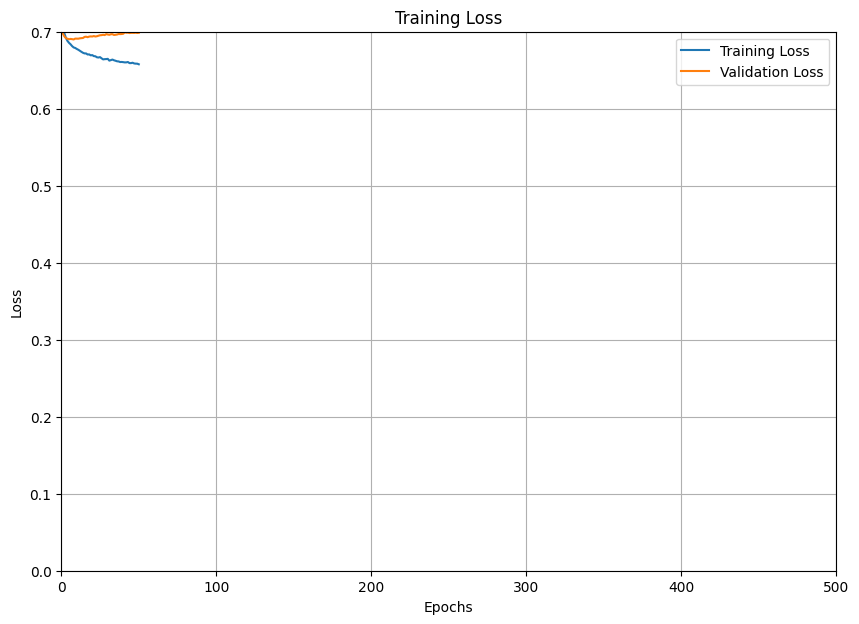

Early stopping at epoch 58 with validation loss: 0.6900
y_pred shape: (94, 250, 80)


In [28]:
#training loop
train_loader, x_test, y_test, x_validation, y_validation = prep_data(l_al, a_al, batch_size = 32, shuffle = True)

n_neurons_in, n_target_neurons = x_test.shape[2], y_test.shape[2]
print('n_neurons:', n_neurons_in)
model_left = SpikeConv1DNet(input_dim = n_neurons_in, output_dim = n_target_neurons, kernel_size = 5, dropout = 0.3)

criterion = combined_loss
loss_history_left, vlidation_loss_history_left = train(model_left, train_loader, x_validation, y_validation,
                 criterion, epochs = 500, lr = 0.005, patience = 50)

y_pred_trained_l = model_left(x_test).detach().numpy()
print('y_pred shape:', y_pred_trained_l.shape)


this is overfitting - still working to resolve this

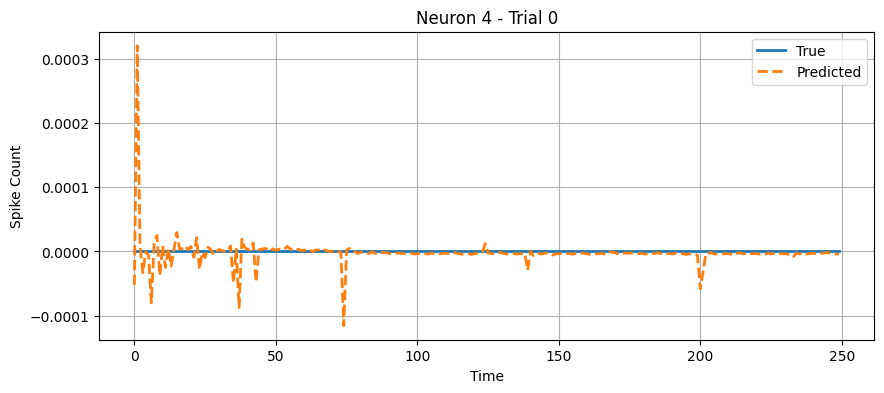

In [33]:
import matplotlib.pyplot as plt

def plot_neuron_prediction(y_true, y_pred, neuron_idx=0, trial_idx=0):
    true_trace = y_true[trial_idx, :, neuron_idx]
    pred_trace = y_pred[trial_idx, :, neuron_idx]

    plt.figure(figsize=(10, 4))
    plt.plot(true_trace, label='True', linewidth=2)
    plt.plot(pred_trace, label='Predicted', linewidth=2, linestyle='--')
    plt.xlabel("Time")
    plt.ylabel("Spike Count")
    plt.title(f"Neuron {neuron_idx} - Trial {trial_idx}")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_neuron_prediction(y_test.numpy(), y_pred_trained_l, neuron_idx=4)



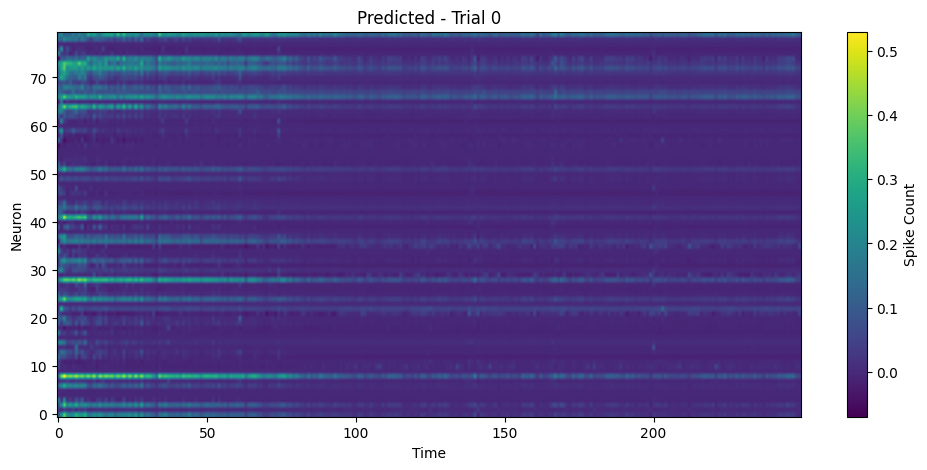

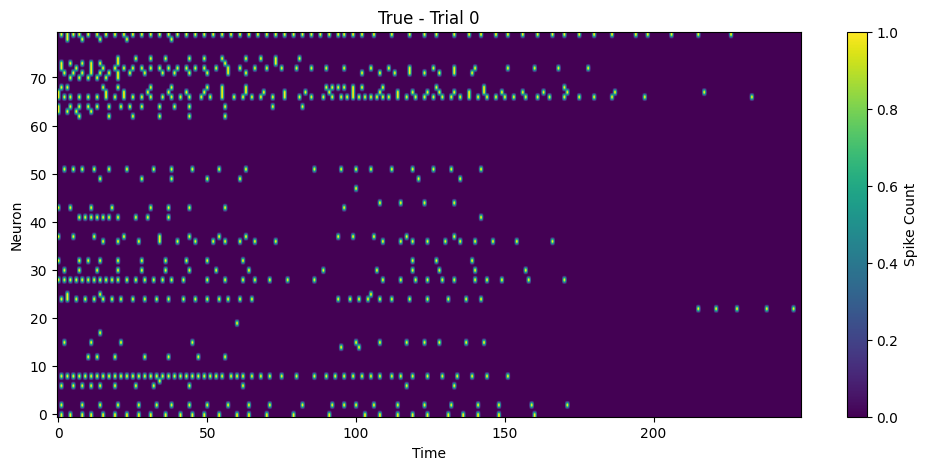

In [34]:
def plot_trial_heatmap(y, trial_idx=0, title=''):
    plt.figure(figsize=(12, 5))
    plt.imshow(y[trial_idx].T, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Spike Count')
    plt.xlabel("Time")
    plt.ylabel("Neuron")
    plt.title(f"{title} - Trial {trial_idx}")
    plt.show()


plot_trial_heatmap(y_pred_trained_l, title='Predicted')
plot_trial_heatmap(y_test.numpy(), title='True')


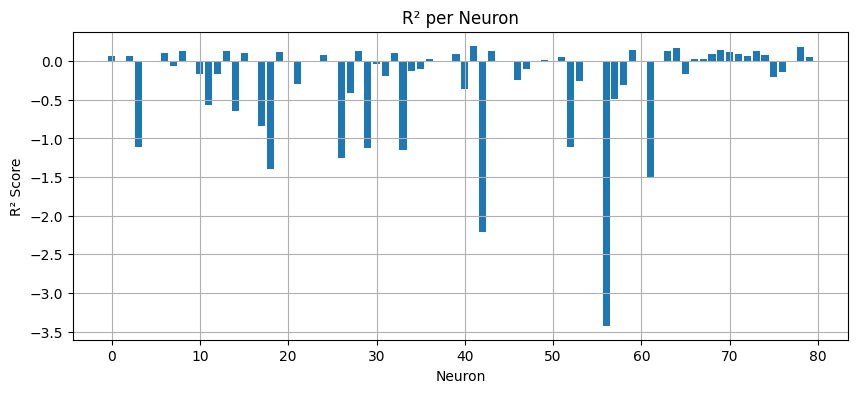

In [35]:
from sklearn.metrics import r2_score

def neuron_wise_r2(y_true, y_pred):
    n_neurons = y_true.shape[2]
    r2s = []
    for i in range(n_neurons):
        r2 = r2_score(y_true[:, :, i].flatten(), y_pred[:, :, i].flatten())
        r2s.append(r2)
    return np.array(r2s)

r2_vals = neuron_wise_r2(y_test.numpy(), y_pred_trained_l)
plt.figure(figsize=(10, 4))
plt.bar(np.arange(len(r2_vals)), r2_vals)
plt.xlabel("Neuron")
plt.ylabel("R² Score")
plt.title("R² per Neuron")
plt.grid(True)
plt.show()


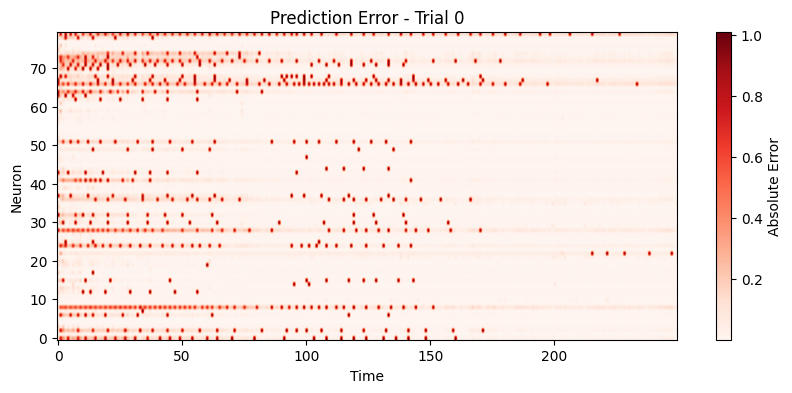

In [37]:
def plot_error_heatmap(y_true, y_pred, trial_idx=0):
    error = np.abs(y_true[trial_idx] - y_pred[trial_idx])
    plt.figure(figsize=(10, 4))
    plt.imshow(error.T, aspect='auto', origin='lower', cmap='Reds')
    plt.colorbar(label='Absolute Error')
    plt.xlabel("Time")
    plt.ylabel("Neuron")
    plt.title(f"Prediction Error - Trial {trial_idx}")
    plt.show()
plot_error_heatmap(y_test.numpy(), y_pred_trained_l, trial_idx=0)

In [ ]:
#training loop
_, _, r_al, _, a_al, _ = collect_data(file_numbers = [1, 2, 4])
train_loader, x_test, y_test, x_validation, y_validation = prep_data(l_al, r_al, batch_size=32, shuffle = True)

n_neurons_in = x_test.shape[2]
print('n_neurons:', n_neurons_in)
model_right = SpikingAttentionLSTM(input_dim = n_neurons_in, hidden_dim = 64, output_dim = 80, num_layers = 1)
# model_skip_right = SpikingAttentionSkipConnection(input_dim = n_neurons_in, hidden_dim = 64, output_dim = 80, num_layers = 1)

criterion = combined_loss()

loss_history_right, vlidation_loss_history_right = train(model_right, train_loader, x_validation, y_validation,
                 criterion, epochs = 2000, lr = 0.01, patience = 30)

y_pred_trained_r = model_right(x_test).detach().numpy()
print('y_pred shape:', y_pred_trained_r.shape)

In [ ]:
trial = 4
neuron = 2

plot_results(
    y_test[trial, :, neuron], y_pred_trained_r[trial, :, neuron],
    'Test Data - True vs Predicted'
)

plot_results(
    y_test[trial].mean(axis = 1), y_pred_trained_r[trial].mean(axis = 1),
    'Test Data - True vs Predicted (mean across neurons)'
)

show_stats(y_test, y_pred_trained_r)